In [13]:
import xarray as xr
import fsspec
from datetime import datetime
import os
import matplotlib.pyplot as plt

path = '/work/users/jn906hluu/S2_Frankenwald_zarr'


In [4]:
list_of_dir = [os.path.join(folder) for folder in os.scandir(path)]
len(list_of_dir)

312

### Generating the final zarr

This is fairly easy from now: load the .zarr directories, use the fsspec mapper to load them with xarray, add a time variable that corresponds to their directory name (just `.split` even if `re` stuff would be cooler...). Then select the bands 1 - 12 which correspond to the physical bands and mask them with the mixed cloud / regionmask. 

In [5]:
list_of_dir.sort()
list_of_xarray_datasets = []
count_failed = 0

for file in list_of_dir:
    date = file.split('/')[-1].split('.')[0]
    dt = datetime.strptime(date, '%Y-%m-%d')
    try:
        ds = xr.open_zarr(fsspec.get_mapper(file), consolidated=True)
        ds = ds.assign_coords({'time' : dt})
        ds = ds.sel(band=slice(1,12))
        ds['refl'] = ds['refl'].where(ds.mask)
        list_of_xarray_datasets.append(ds)
    except:
        count_failed += 1
print(count_failed / len(list_of_dir))

0.0


Now concat them into on big xarray, with dimension time and resample them to monthly resoultion. This is done as there are many cloudy images and ensures that we have a high number of points for every month instead some points every week. 

In [6]:
combined_set = xr.concat(list_of_xarray_datasets, dim='time')

In [7]:
resampled_set = combined_set.resample(time='1M').mean()

Let's take a look at the first one in the red-edge.

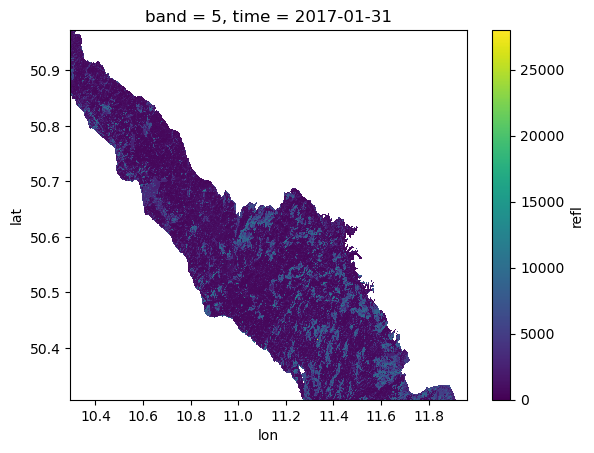

In [8]:
resampled_set.sel(band=5).isel(time=0).refl.plot()

And the same in RGB:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


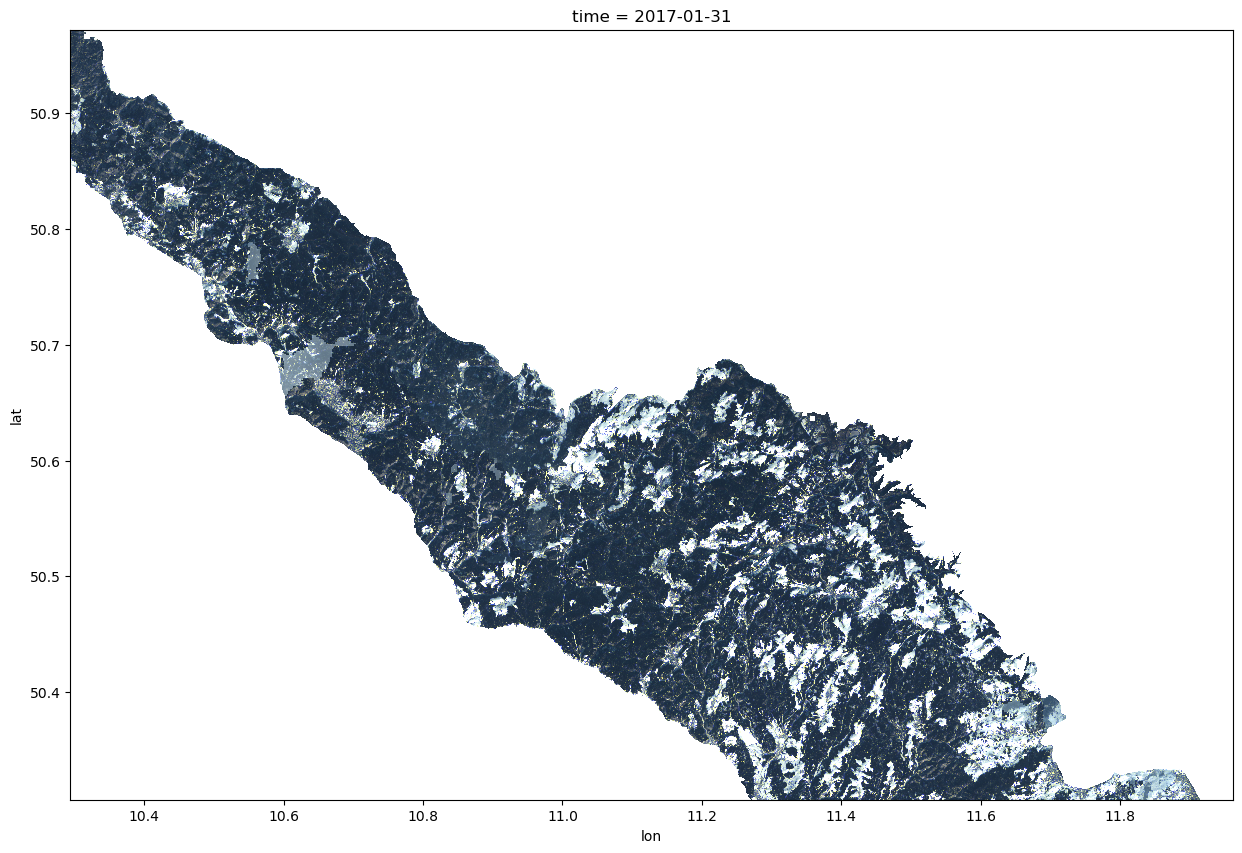

In [14]:
plt.figure(figsize=(15,10))
(resampled_set.sel(band=[3,2,1]).isel(time=0).refl / 1e4 * 1.5).plot.imshow()

### Plotting Climate variables

Here is an example of a daily precipitation dataset from DWD Climate Center. The data can be found at `https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/` just take look and see what variables are available. Sadly I was to lazy to do the regriding for this too, as it has some sublties. I more or less just projected the edges on the images, without considering curverature. I don't know how important it is, but i figure the error can't be too high as we're on a span of 1.4°. 

In [16]:
pr_ds = xr.open_dataset('/work/users/jn906hluu/Climate/Precipitation/pr_hyras_1_2022_v5-0_de.nc')

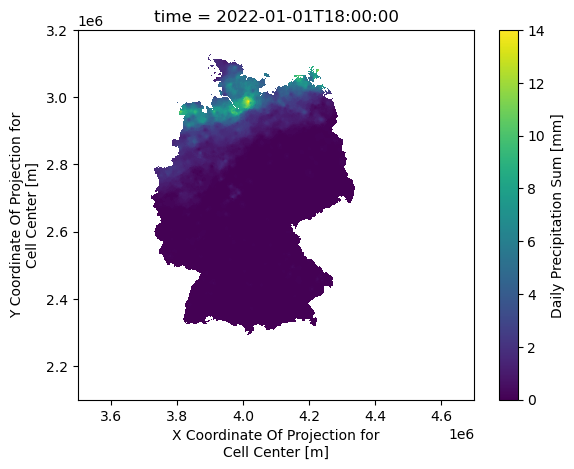

In [17]:
pr_ds.pr.isel(time=0).plot()
